In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, when, regexp_replace
from pyspark.ml.feature import MinMaxScaler, VectorAssembler


spark = SparkSession.builder.getOrCreate()

### Import Data into SPARK Data Frame

In [36]:
metadata = spark.read.csv('metadata.csv', header=True) #Enabling header solves issue of the _c0...n header names

In [37]:
metadata.show()

+----------+----+-------+---------+--------------+------------+-------------+-----------+--------+------------+----------+-------+-----+-------+-------+-------+-------+-------+-------+------------+------------+------------+------------+------------+------------+------+------+------+------+------+------+
| Sample_ID|Year|Country|Continent|Beta.lactamase|Azithromycin|Ciprofloxacin|Ceftriaxone|Cefixime|Tetracycline|Penicillin|NG_MAST|Group|azm_mic|cip_mic|cro_mic|cfx_mic|tet_mic|pen_mic|log2_azm_mic|log2_cip_mic|log2_cro_mic|log2_cfx_mic|log2_tet_mic|log2_pen_mic|azm_sr|cip_sr|cro_sr|cfx_sr|tet_sr|pen_sr|
+----------+----+-------+---------+--------------+------------+-------------+-----------+--------+------------+----------+-------+-----+-------+-------+-------+-------+-------+-------+------------+------------+------------+------------+------------+------------+------+------+------+------+------+------+
|ERR1549286|2015|     UK|   Europe|          null|        >256|         null|      0.

### Preprocessing and Cleaning with Spark

We selected a subset of 9 main preprocessing and cleaning steps that were signifigant.
Then we had to add a series of fixes and patches to get the data in the form that Spark expects. 

In [38]:
from pyspark.sql.functions import skewness
#https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html


#1 Rename invalid column name, Beta Lact.
metadata = metadata.withColumnRenamed("Beta.lactamase", "Beta_lactamase")

#2 Fill NaN values with 0.0 for specific columns - This is because these are our labels and we will just assume that missing data is a negative because negatives are signifigantly more common
metadata = metadata.fillna({"azm_sr": 0.0, "cfx_sr": 0.0, "cip_sr": 0.0})

#3 Drop unnecessary labels - Year has little bearing, thus we drop it. The rest are labels we have no interest in using
useless_columns = ["Year", "cro_sr", "tet_sr", "pen_sr"]
metadata = metadata.drop(*useless_columns)

#4 Dropping Duplicate
metadata = metadata.dropDuplicates()

#5 Remove symbols from string columns
def remove_symbols_from_column(df):
    #Get collection of string fields
    string_columns = [field.name for field in df.schema.fields if field.dataType == "StringType"]

    for col_name in string_columns:
        #Straight up remove symbols
        df = df.withColumn(col_name, regexp_replace(col(col_name), r"[^a-zA-Z0-9]", ""))
    return df

metadata = remove_symbols_from_column(metadata)

#6 Convert specified columns to the appropriate numeric type (float)
numeric_columns = [
    'Azithromycin', 'Ciprofloxacin', 'Ceftriaxone', 'Cefixime', 
    'Tetracycline', 'Penicillin', 
    'NG_MAST', 'Group', 'azm_mic', 'cip_mic', 'cro_mic', 'cfx_mic', 'tet_mic', 'pen_mic', 
    'log2_azm_mic', 'log2_cip_mic', 'log2_cro_mic', 'log2_cfx_mic', 'log2_tet_mic', 'log2_pen_mic'
]

for column in numeric_columns:
    metadata = metadata.withColumn(column, col(column).cast("float"))


#7 Just splitting for what comes next
train_inputs, test_inputs = metadata.randomSplit([0.8, 0.2], seed=69)

#8 Select the columns we determined to be the most impactful during our EDA steps. Also includes needed columns. This step also drops Sample_ID
best_columns = ['Group', 'azm_mic', 'log2_azm_mic', 'log2_cip_mic', 'cip_mic', 'cro_mic', 
    'cfx_mic', 'log2_cro_mic', 'log2_cfx_mic', 'Ciprofloxacin', 'Cefixime', 
    'Tetracycline', 'Penicillin', 'log2_tet_mic', 'log2_pen_mic', 'azm_sr'
]


#9 Impute Nulls - Ditched skew based for complexity reasons
def impute_nulls(df, columns):

    for column_name in columns:

        impute_value = df.select(mean(col(column_name))).collect()[0][0]
        
        #Impute null values with the calced value
        df = df.withColumn(column_name, when(col(column_name).isNull(), impute_value).otherwise(col(column_name)))
    return df

train_inputs = impute_nulls(train_inputs, numeric_columns)
test_inputs = impute_nulls(test_inputs, numeric_columns)


#==========================================================================================================
#The mess begins below


#Prepare data for modeling
#Effectively the squeeze from before but will try to use vector assembler https://spark.apache.org/docs/3.4.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html
#https://spark.apache.org/docs/latest/ml-features.html#vectorassembler
#https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.select.html
feature_cols = [col for col in best_columns if col not in ['azm_sr']]
vec_asm_out = VectorAssembler(inputCols=feature_cols, outputCol="features")

#Transform data to include feature vectors
train_data = vec_asm_out.transform(train_inputs).select("features", col("azm_sr").alias("label"))
test_data = vec_asm_out.transform(test_inputs).select("features", col("azm_sr").alias("label"))

#FIXES BELOW

#Models gave error not liking negatives so we need to scale
scaler = MinMaxScaler(inputCol="features", outputCol="scaled")
scaler_model = scaler.fit(train_data)

train_data = scaler_model.transform(train_data).select("scaled", col("label"))
test_data = scaler_model.transform(test_data).select("scaled", col("label"))

train_data = train_data.withColumnRenamed("scaled", "features")
test_data = test_data.withColumnRenamed("scaled", "features")

#Edit 1: To fix error that labels were strings and not floats
#Edit 2: Fix error that labels were floats and not ints
train_data = train_data.withColumn("label", col("label").cast("int"))
test_data = test_data.withColumn("label", col("label").cast("int"))


#Take care of magic nulls that somehow arent present in the DF but are present in the vector
#https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.when.html
train_data = train_data.withColumn("label", when(col("label").isNull(), 0).otherwise(col("label")))
test_data = test_data.withColumn("label", when(col("label").isNull(), 0).otherwise(col("label")))





In [39]:
train_inputs.show()
print(train_data)

+----------+--------+---------+--------------+--------------------+--------------------+--------------------+--------------------+------------------+-----------------+------------------+-----+--------------------+--------------------+--------------------+--------------------+------------------+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+------+------+------+
| Sample_ID| Country|Continent|Beta_lactamase|        Azithromycin|       Ciprofloxacin|         Ceftriaxone|            Cefixime|      Tetracycline|       Penicillin|           NG_MAST|Group|             azm_mic|             cip_mic|             cro_mic|             cfx_mic|           tet_mic|          pen_mic|       log2_azm_mic|       log2_cip_mic|       log2_cro_mic|       log2_cfx_mic|       log2_tet_mic|        log2_pen_mic|azm_sr|cip_sr|cfx_sr|
+----------+--------+---------+--------------+--------------------+--------------------+

### Eval code

Largely inherited from last phase with modifications to convert spark df into pandas df (for eval only)

General Guidelines for ROC Curves and such:

AUC close to 1 -> Very Good \
AUC ~ 0.5 -> Like random guessing \
AUC < 0.5 -> Really bad

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd



#Plot ROC Curve
def plot_roc_curve(y_test, y_probs, name):


    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Score: ' + str(name))
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

#Eval Classification
def eval_classification(y_test_SPARK, y_pred_SPARK, name):

    #Convert Spark DataFrames to pandas for EVAL ONLY

    if isinstance(y_test_SPARK, pd.DataFrame):
        y_test = y_test_SPARK.squeeze()
    else:
        y_test = y_test_SPARK.toPandas().squeeze()

    
    if isinstance(y_pred_SPARK, pd.DataFrame):
        y_pred_probs = y_pred_SPARK.squeeze() 
    else:
        y_pred_probs = y_pred_SPARK.toPandas().squeeze() 

    #Retired old threshold function in favor of simpelr one
    y_pred = (y_pred_probs > 0.5).astype(float) 

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, label='Actual', color='blue', marker='o')
    plt.scatter(range(len(y_pred)), y_pred, label='Predicted', color='red', marker='x')
    plt.yticks([0, 1.0])
    plt.ylim(-0.4, 1.4) #Offsets for prettying. Adjust if your resolution screws someting up
    plt.title('CLASSIFICATION - Predictions vs Ground Truth: ' + str(name))
    plt.ylabel('Super Resistance')
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_roc_curve(y_test, y_pred, name)

    return metrics

In [41]:

train_data.filter(col("label").isNull()).show()
test_data.filter(col("label").isNull()).show()

+--------+-----+
|features|label|
+--------+-----+
+--------+-----+

+--------+-----+
|features|label|
+--------+-----+
+--------+-----+



### ML Section

## 1. Naive Bayes

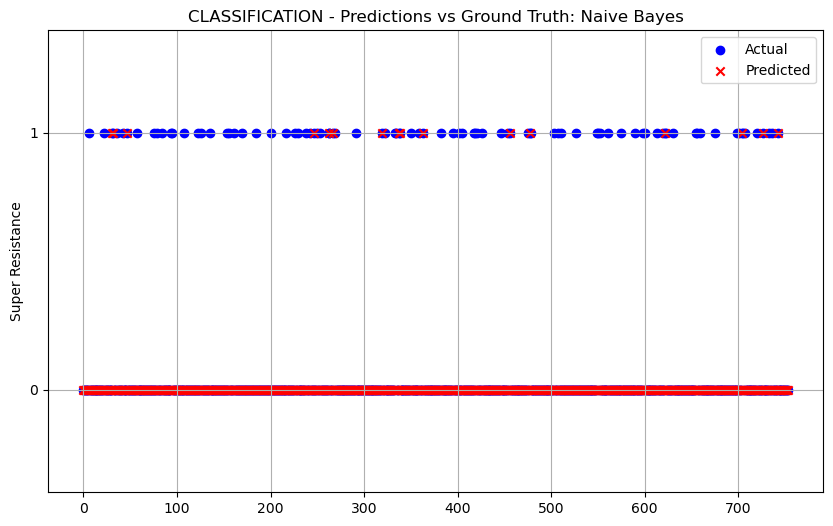

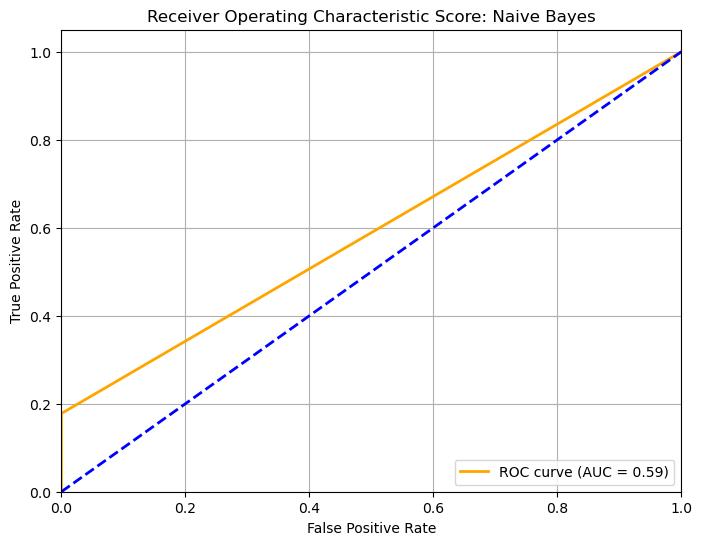

{'Accuracy': 0.9018567639257294, 'Precision': 0.9116976846161035, 'Recall': 0.9018567639257294, 'F1 Score': 0.8701893046611113}


In [42]:
from pyspark.ml.classification import NaiveBayes

def naive_bayes_spark(train_data, test_data):

    model = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="prediction")
    model = model.fit(train_data)
    
    predictions = model.transform(test_data)

    y_test_SPARK = test_data.select("label")
    y_pred_SPARK = predictions.select("prediction")

    metrics = eval_classification(y_test_SPARK, y_pred_SPARK, "Naive Bayes")
    print(metrics)

naive_bayes_spark(train_data, test_data)

## 2. Logistic Regression

Same as before, 10 iterations for consistency

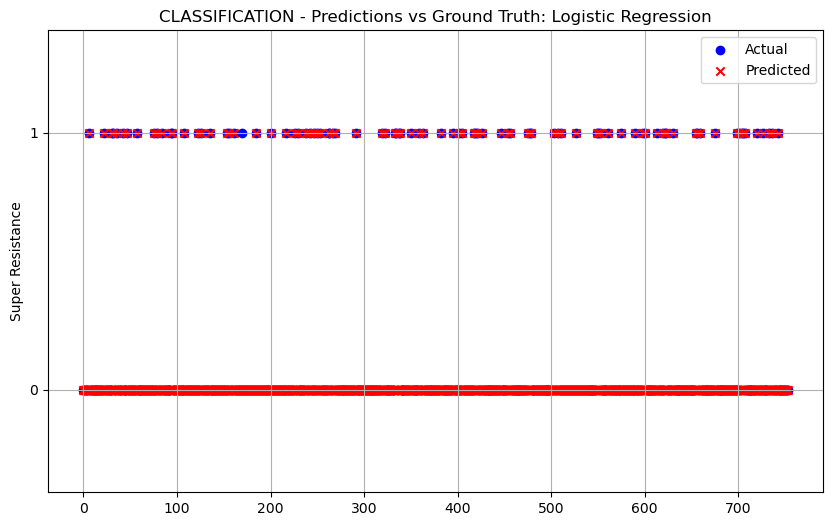

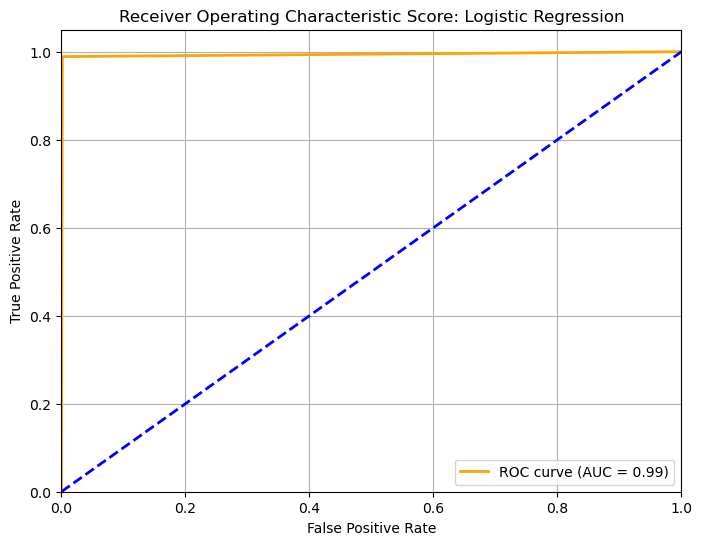

{'Accuracy': 0.9973474801061007, 'Precision': 0.9973474801061007, 'Recall': 0.9973474801061007, 'F1 Score': 0.9973474801061007}


In [43]:
from pyspark.ml.classification import LogisticRegression

def logistic_regression_spark(train_data, test_data):


    model = LogisticRegression(featuresCol="features", labelCol="label", predictionCol="prediction",  maxIter=10)
    model = model.fit(train_data)
    
    predictions = model.transform(test_data)

    y_test_SPARK = test_data.select("label")
    y_pred_SPARK = predictions.select("prediction")


    metrics = eval_classification(y_test_SPARK, y_pred_SPARK, "Logistic Regression")
    print(metrics)

logistic_regression_spark(train_data, test_data)

## 3. Support Vector Machine

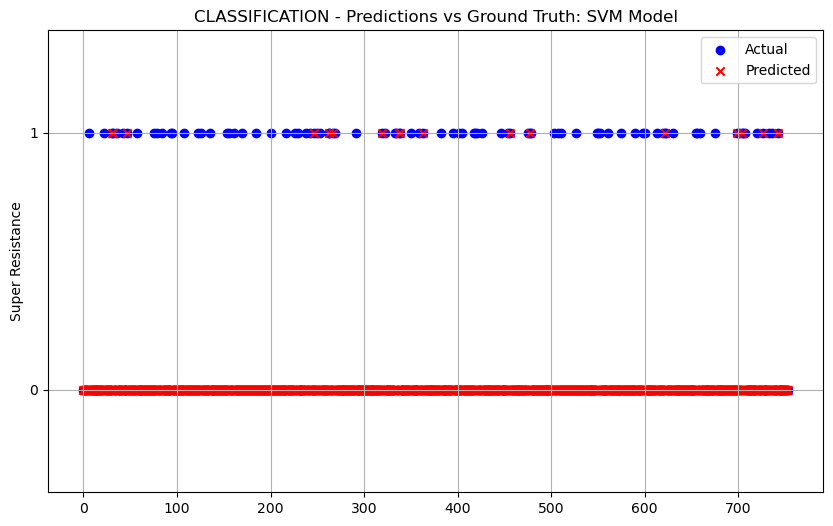

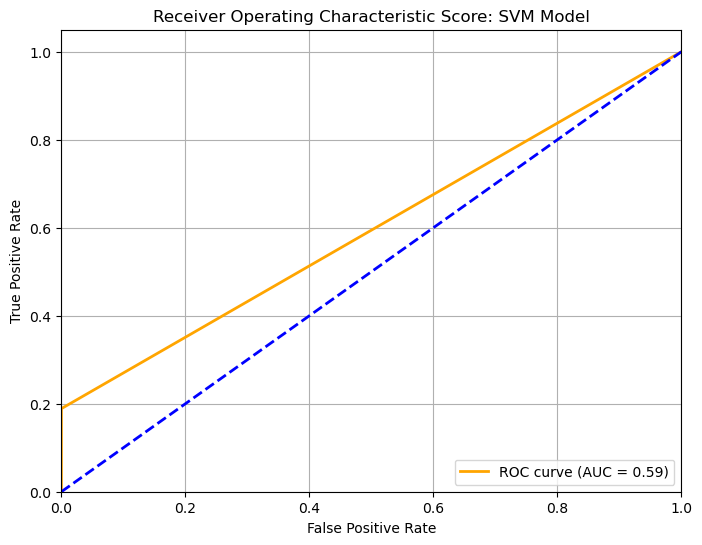

{'Accuracy': 0.903183023872679, 'Precision': 0.9127727650630378, 'Recall': 0.903183023872679, 'F1 Score': 0.8726790273984016}


In [44]:
from pyspark.ml.classification import LinearSVC

def SVM_model_spark():
    svm = LinearSVC(featuresCol='features', labelCol='label', maxIter=10, regParam=0.1)
    svm_model = svm.fit(train_data)

    predictions = svm_model.transform(test_data)

    y_test_SPARK = test_data.select("label")
    y_pred_SPARK = predictions.select("prediction")

    metrics = eval_classification(y_test_SPARK, y_pred_SPARK, "SVM Model")
    print(metrics)
    
SVM_model_spark()

[18:23:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

     label  prediction
0        0    0.000016
1        0    0.000016
2        0    0.000016
3        0    0.000016
4        0    0.000016
..     ...         ...
749      0    0.000016
750      0    0.000016
751      0    0.000016
752      0    0.000016
753      0    0.000016

[754 rows x 2 columns]


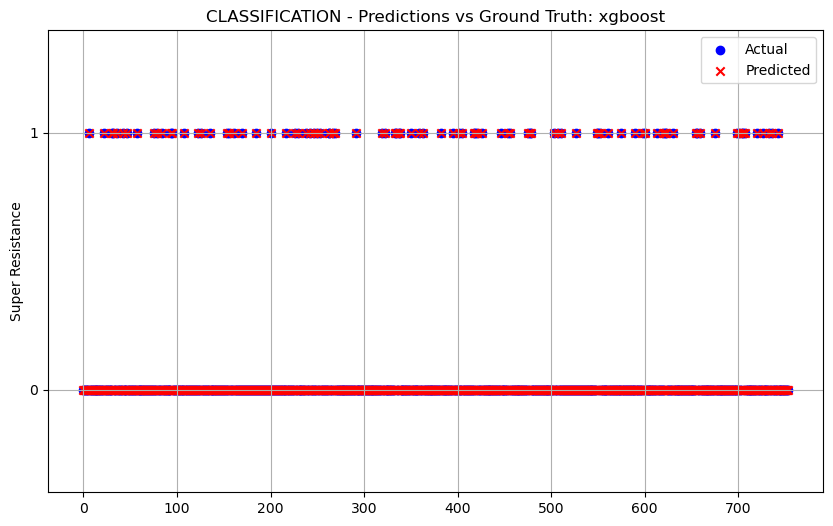

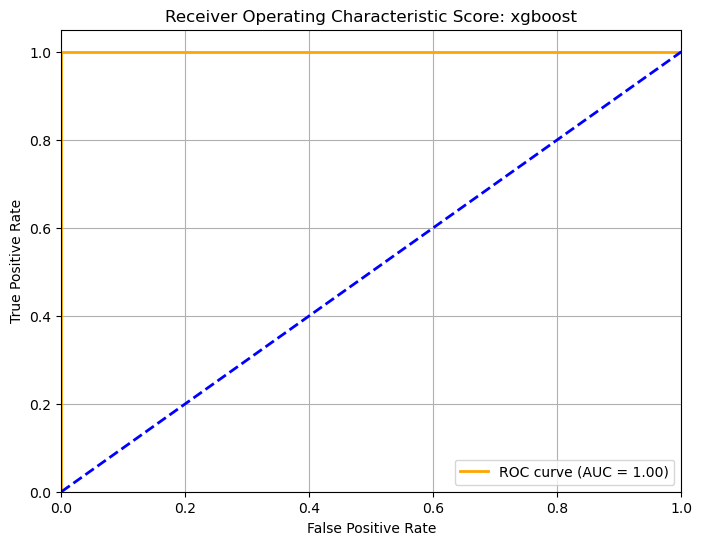

{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}


In [45]:
import xgboost as xgb
import pandas as pd
from pyspark.ml.feature import VectorAssembler

def XGBoost_model_spark(train_data, test_data):
    train_pandas = train_data.select("features", "label").toPandas()
    test_pandas = test_data.select("features", "label").toPandas()

    train_features = pd.DataFrame(train_pandas['features'].tolist())
    test_features = pd.DataFrame(test_pandas['features'].tolist())

    X_train = train_features.values
    y_train = train_pandas['label'].values
    X_test = test_features.values
    y_test = test_pandas['label'].values

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',  
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100
    }

    xgb_model = xgb.train(params, dtrain, num_boost_round=100)

    predictions = xgb_model.predict(dtest)

    test_pandas['prediction'] = predictions

    print(test_pandas[['label', 'prediction']])

    y_test_df = test_data.select('label')
    y_pred_df = pd.DataFrame({"prediction" : predictions})
    
    metrics = eval_classification(y_test_df, y_pred_df, "xgboost")

XGBoost_model_spark(train_data, test_data)


## 4. Neural Network

/home/jacob/.conda/envs/cse487-proj/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.8121 - loss: 0.3873
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.9823 - loss: 0.0725
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.9841 - loss: 0.0496
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.9814 - loss: 0.0575
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.9810 - loss: 0.0539
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.9936 - loss: 0.0221
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.9989 - loss: 0.0087
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.9993 - loss: 0.0058
Epoch 9/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.9947 - loss: 0.0271
Epoch 10/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.9852 - loss: 0.0414
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


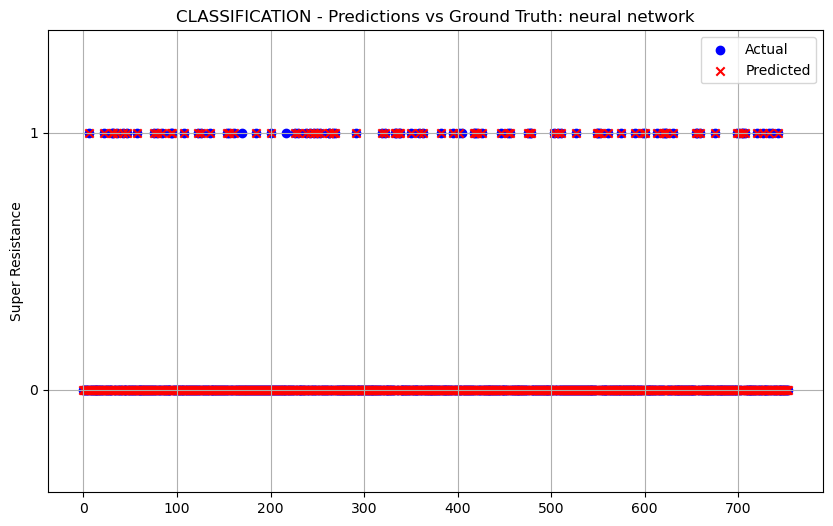

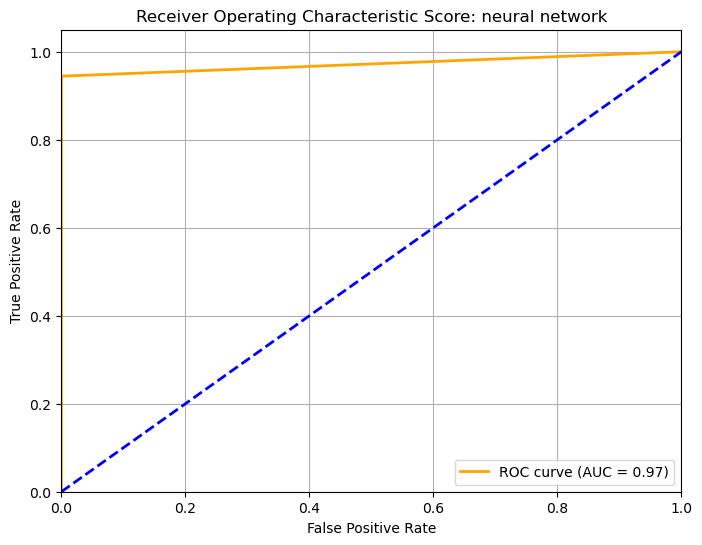

{'Accuracy': 0.993368700265252, 'Precision': 0.9934182615487703, 'Recall': 0.993368700265252, 'F1 Score': 0.9932864042081002}


In [46]:
import tensorflow as tf
from tensorflowonspark import TFCluster
import numpy as np
from pyspark.sql import Row
import pandas as pd
from pyspark.sql.types import StructType, StructField, FloatType

def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(input_shape,)),  # Pass a tuple with one element
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(4, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

def map_function(row):
    features = np.array(row['features'].toArray())
    label = row['label']
    return (features, label)

train_data_numpy = train_data.select('features', 'label').collect()
test_data_numpy = test_data.select('features', 'label').collect()

X_train = np.array([x[0] for x in train_data_numpy])
y_train = np.array([x[1] for x in train_data_numpy])

X_test = np.array([x[0] for x in test_data_numpy])
y_test = np.array([x[1] for x in test_data_numpy])

def neural_network():
    epochs = 10

    columns = X_train.shape[1]
    model = build_model(columns)

    print(model.summary())

    model.fit(X_train, y_train, epochs=epochs, batch_size=32)

    y_pred = model.predict(X_test)
    y_pred = [float(p[0]) for p in y_pred]  # Ensure predictions are converted to float

    y_pred_df = pd.DataFrame({"prediction" : y_pred})

    y_test_df = test_data.select('label')

    print(eval_classification(y_test_df, y_pred_df, "neural network"))

neural_network()

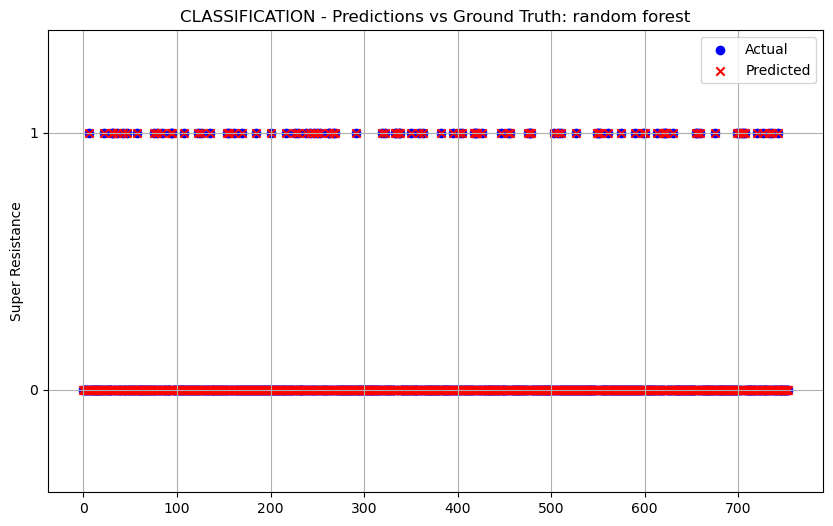

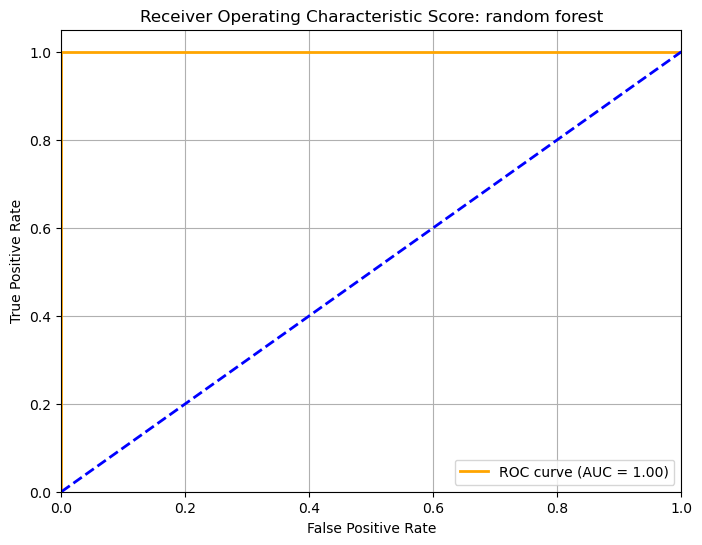

{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}


In [47]:
from pyspark.ml.classification import RandomForestClassifier

def random_forest():
    rf = RandomForestClassifier(labelCol="label", featuresCol="features", predictionCol="prediction", numTrees=10)

    # Train the model
    model = rf.fit(train_data)

    predictions = model.transform(test_data)

    y_test_SPARK = test_data.select("label")
    y_pred_SPARK = predictions.select("prediction")
  
    print(eval_classification(y_test_SPARK, y_pred_SPARK, "random forest"))

random_forest()

In [48]:
spark.stop()